# Faux SNN

## Code
I realized numpy is a thing, so all the code will be directly in this notebook.  

Let it be noted for anyone reading this that I was well aware of numpy before this, but I was having a passionate love affair with Rust which blinded me to the fact that numpy is actually probably better suited for my machine learning needs.

## Intro

* **Date**: 11/24/2020  
* **What**: This is an ANN architecture that essentially uses a form of Hebbian learning to learn its weights.  This network basically works on the principle that if the synapse and the neuron fire in step, the synapse is strengthened.  Otherwise, if either the pre-synaptic or post-synaptic neuron fire alone and out of step, the synapse is weakened.  The firing rate is abstracted as a floating-point value, but this is the underlying principle governing learning.  
* **Why**: Because [this](https://www.frontiersin.org/articles/10.3389/fncom.2015.00099/full) SNN is haunting my dreams!  I really feel like we homo sapiens should be able to build an ANN that behaves like an SNN and is way more efficient.  Abstract over all the stochastic spikes instead of having to simulate each one individually.  That's the dream.  And a fragment (grammatically speaking).  But I don't want to make an efficient SNN just for the sake of making an SNN.  SNNs seem capable of doing effortless competitive learning, which is really dope, and also one-shot learning, which is really really dope.  If I could recreate that sort of effect using an analog ANN, that would have to be way more efficient, and would allow me to "easily" slap it on an FPGA and watch it go.  
* **Hopes**: I really, really hope that neurons in this network individually display pattern competition, where recurring patterns compete to be represented by a neuron.  I also really hope that together, through inhibitory synapses, neurons display competitive behaviors, so each neuron represents a particular, unique pattern.  I'm really squaring off with [this](https://www.pnas.org/content/116/16/7723) architecture, which is really doing a pretty simple type of "bio-plausible" competitive learning (I do love the part where the weight vector is kept to the unit sphere.  That's fantastic).  The problem with that network (well, there are a lot of problems with it), is that certain neurons don't ever win, so they basically remain uninitialized forever.  Other neurons win a bit, and so they develop noisy shadows of mnist digits, but they also barely ever update.  In the [Diehl network](https://www.frontiersin.org/articles/10.3389/fncom.2015.00099/full), after one epoch, 100 neurons had already latched onto 100 separate unique prototypes (and got the 85% classification score that's also been haunting me) after only one epoch.  That's so incredibly dope.  Those are the sorts of behaviors I want to see from this bad boi.    
* **Limitations**: I honestly don't really know yet.  I guess the ANN community loves backprop because you can mini-batch learning (among all the other reasons to love backprop).  Mini-batches are pretty cool, and I super don't think they naturally work with this architecture.  I just have pretty high hopes for this network.  Luckily I have enough experience with these experiments to know that it'll probably come crashing to the ground for one reason or other.

## Technicals

Really the only thing of any note here is the learning step, so I'll describe how that works.  A neuron's output takes a value between 0 and 1.  Let $m_i$ be the measure (output) of the pre-synaptic neuron, and let $m_o$ be the measure of the post-synaptic neuron.  Let $w_{j}$ be the weight of synapse connecting these two neurons on the $j^{th}$ iteration of the network.  A synapse can have a minimum weight of 0 and let the max value of the synapse be $w_{max}$.  Finally, $a$, $b$ and $c$ are constants that dictate learning speed.  We then have:

$$
\gamma = m_o - m_i \cdot m_o
$$
$$
\zeta = m_i - m_i \cdot m_o
$$
$$
\lambda = m_i \cdot m_o
$$

$$
w_{j + 1} = w_{max} - w_{max} e^{-c\lambda} + w_{j}e^{-a\gamma}e^{-b\zeta}e^{-c\lambda} 
$$

These equation may be difficult to interpret by themselves, so here's how they work.  Think of one iteration of the loop as an expanse in time, split up into $n$ smaller pieces of time, called bins.  Let there be $m_i n$ "input" balls and $m_o n$ "output" balls distributed amongst the bins so that no more than one type of each ball can be in a single bin.  Then, it is most probable that there will be $n(m_i m_o)$ bins that contain both types of balls, $n(m_i - m_i \cdot m_o)$ bins that only contain "input" balls, and $n(m_o - m_i \cdot m_o)$ bins that only contain "output" balls. Now then, if you think of each bin containing at least one ball as a firing event, then synapse should be rewarded when a bin contains "input" and "output" balls, meaning the pre-synaptic and post-synaptic neurons fired in-line, and the synapse should decay if a bin only contains one ball, which implies the pre and post neurons didn't fire together.

Thus, the $\gamma$ and $\zeta$ terms dictate how much the weight is going to decay in a given iteration of the network, and the $\lambda$ term dictates how much the synapse will strengthen in a given iteration.  Also note that there's some level of choice in what order you apply the exponential terms to the original weight, and I chose to order them so that the effect of the strengthening term is as great as possible.  I would assume the order of the application of exponentials doesn't really matter if all neurons are treated the same, but I could obviously be wrong about that, and if this architecture works like I want it to, it might be a good idea to look into it empirically.

Also, a neuron's output is calculated as follows.  Let $o$ be the output, and let $q_i$ and $w_i$ be the pre-synaptic measures and weights feeding into this neuron, respectively.  Then

$$
o = \sigma \left(\sum_{i} q_i  w_i \right)
$$

where $\sigma$ is bounded, monotonically increasing function between 0 and 1 with the property that $x < 0 \Rightarrow \sigma(x) = 0$.  So a basic perceptron with additional constraints on the output function. 

## Code

In [52]:
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras.datasets import mnist
from tqdm import tqdm

L = 28 * 28   #Size of mnist in pixels
S = 60000     #Size of training set

(train_X, train_y), (test_X, test_y) = mnist.load_data()
train_X = train_X / 255.0

flat_x = np.reshape(train_X, [-1, 1, L])

In [21]:
# Weight plotter visciously stolen from bio network paper
def draw_weights(synapses, Kx, Ky):
    yy=0
    HM=np.zeros((28*Ky,28*Kx))
    for y in range(Ky):
        for x in range(Kx):
            HM[y*28:(y+1)*28,x*28:(x+1)*28]=synapses[yy,:].reshape(28,28)
            yy += 1
    plt.clf()
    nc=np.amax(np.absolute(HM))
    im=plt.imshow(HM,cmap='bwr',vmin=0,vmax=nc)
    fig.colorbar(im,ticks=[0, np.amax(HM)])
    plt.axis('off')
    fig.canvas.draw()

In [205]:
def run_exp(w_max, w_max_in, Nep, a, b, c, a_in, b_in, c_in, Kx, Ky, flat_x):
    fig=plt.figure(figsize=(12.9,10))

    # Excitatory synpases
    w_ex = np.random.normal(w_max / 2, w_max / 2, (N, L)).clip(min=0, max=w_max)

    # Inhibitory synapses
    w_in = np.random.normal(w_max_in / 2, w_max_in / 2, (N, N)).clip(min=0, max=w_max_in)
    np.fill_diagonal(w_in, 0)

    for ep in range(Nep):
    #     flat_x = flat_x[np.random.permutation(S), :]

        for i in tqdm(range(T_s)):
            q = flat_x[i]
            p1 = w_ex @ q.T
            sig1 = activation(p1)
            p2 = p1 - (w_in @ sig1)

            sig2 = activation(p2)

            l1 = sig2 @ q
            g1 = sig2 - l1
            z1 = q - l1

            exp_l1 = np.exp(-1 * c * l1)

            w_ex = w_max - (w_max * exp_l1) + (w_ex * np.exp(-1 * a * g1) * np.exp(-1 * b * z1) * exp_l1)

            l2 = sig2 @ sig2.T
            g2 = sig2 - l2
            z2 = sig2.T - l2

            exp_l2 = np.exp(-1 * c_in * l2)

            w_in = w_max_in - (w_max_in * exp_l2) + (w_in * np.exp(-1 * a_in * g2) * np.exp(-1 * b_in * z2) * exp_l2)

            #IMPORTANT: Re-zero diagonal of w_in because neurons don't have inhibitory synapses to themselves
            np.fill_diagonal(w_in, 0)

        print(np.amax(w_in))
        draw_weights(w_ex, Kx, Ky)

100%|██████████| 1000/1000 [00:00<00:00, 1287.08it/s]


12.665812589224862


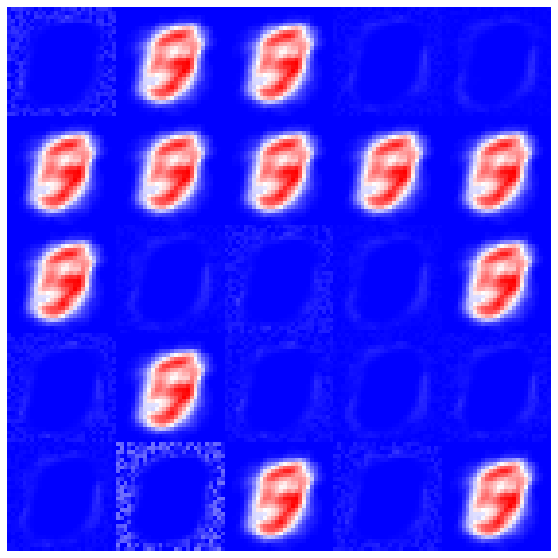

In [210]:
Kx = 5 
Ky = 5
N = Kx * Ky    #Number of neurons
Nep = 1        #Number of epochs
T_s = 1000     #Number of training images

# Constants from technicals section
a = 0.01
b = 0.05
c = 0.01

a_in = 0.001
b_in = 0.001
c_in = 0.001

w_max = 10
w_max_in = 13

# Activation function
def activation(x):
    return np.tanh(x / 50).clip(min=0)

run_exp(w_max, w_max_in, Nep, a, b, c, a_in, b_in, c_in, Kx, Ky, flat_x)   

## Analysis Dialog

Just as a quick note, when I use python, I'll include the code in the code section right before the analysis dialog.  

Well, true to my predictions in the limitations section, everything broke.  Well, it didn't necessarily break, but it just doesn't work.  The image above is about as "diverse" as I was able to get the weight prototypes.  Not super diverse.  Let me throw some other parameters in and show you what typically happens.  So first, here's an example when the inhibitory neurons aren't very strong:

100%|██████████| 1000/1000 [00:00<00:00, 1266.30it/s]


0.9995139186920639


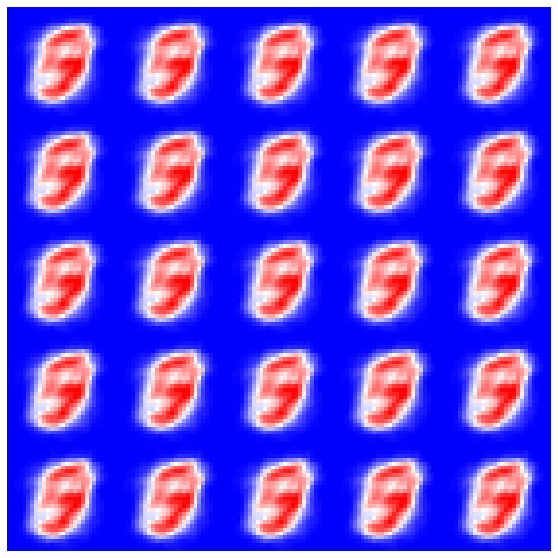

In [211]:
Kx = 5 
Ky = 5
N = Kx * Ky    #Number of neurons
Nep = 1        #Number of epochs
T_s = 1000     #Number of training images

# Constants from technicals section
a = 0.01
b = 0.01
c = 0.01

a_in = 0.001
b_in = 0.001
c_in = 0.001

w_max = 10
w_max_in = 1

run_exp(w_max, w_max_in, Nep, a, b, c, a_in, b_in, c_in, Kx, Ky, flat_x)   

Yup, literally all the same.  This is to be expected, I suppose, because inhibition is the only thing striving to keep the neurons diverse, and there isn't much of it.  Now, let's make the inhibition too large.

100%|██████████| 1000/1000 [00:00<00:00, 1345.83it/s]


16.44182967122896


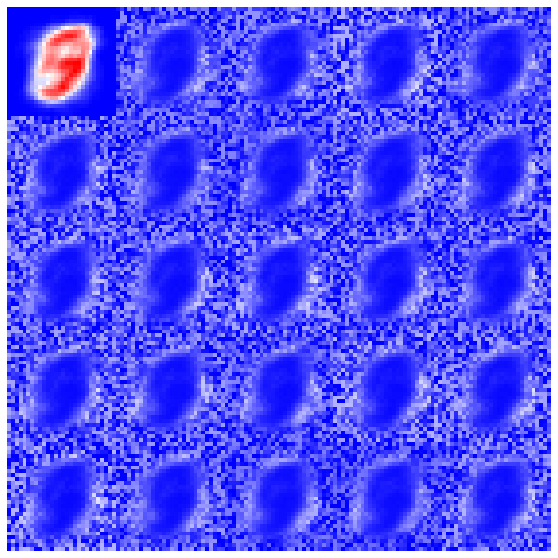

In [216]:
Kx = 5 
Ky = 5
N = Kx * Ky    #Number of neurons
Nep = 1        #Number of epochs
T_s = 1000     #Number of training images

# Constants from technicals section
a = 0.01
b = 0.01
c = 0.01

a_in = 0.01
b_in = 0.01
c_in = 0.01

w_max = 10
w_max_in = 20

run_exp(w_max, w_max_in, Nep, a, b, c, a_in, b_in, c_in, Kx, Ky, flat_x)   

Well, that happened.  And just as salt in the wounds, if you look closely at the shadow neurons, what do they look like?  FUZZY F@%$#ing threes!  I hate fuzzy threes so much.  And if I up the inhibition just a bit more...

100%|██████████| 1000/1000 [00:00<00:00, 1353.94it/s]


16.322097124695816


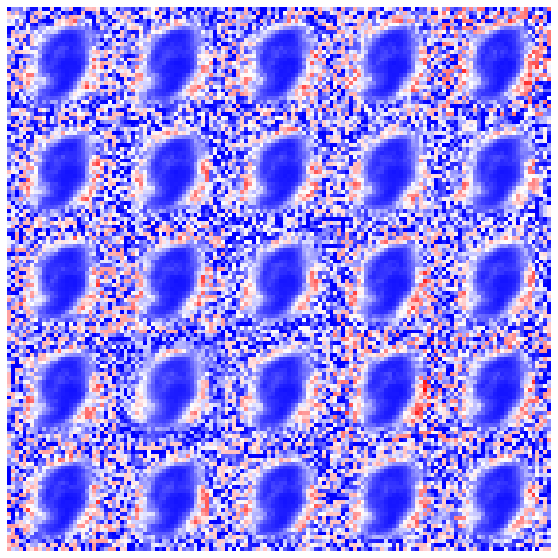

In [218]:
Kx = 5 
Ky = 5
N = Kx * Ky    #Number of neurons
Nep = 1        #Number of epochs
T_s = 1000     #Number of training images

# Constants from technicals section
a = 0.01
b = 0.01
c = 0.01

a_in = 0.01
b_in = 0.01
c_in = 0.01

w_max = 10
w_max_in = 20

run_exp(w_max, w_max_in, Nep, a, b, c, a_in, b_in, c_in, Kx, Ky, flat_x)   

Well, I didn't change the parameters so I'm not sure what happened, but this illustrates my point well.  Sometimes, none of the neurons have a prototype!  Ain't that the darndest thang you ever saw.  

Anyway, all this is to say that the current architecture straight up doesn't work.  Diehl has won again.  That just boils my blood.  There's not much more to say here, so I think I'll just mosey on over to the conclusions section.

# Conclusions

Well, this one hurts.  I was really hoping this network would do some cool things.  But I guess not this time.  Anyway, let's talk about why it doesn't work.

I can't help but think that the activation function is to blame.  The simple "sum and activate" is just too simple.  There's not enough subtly there to actually do everything I want it to do (i.e. capture its input prototype, AND respond properly to inhibitory impulses).  If I make the inhibition too large, then it basically ensures that nothing ever gets learned.  If I make it too small, then the neurons all tend toward the same state.  I need something that simply fits my specification in a superior manner.  

So why do SNNs work?  I think there are a couple things.  First, everything's stochastic.  Nothing like randomness to keep neurons from tending towards the same state.  Also, graded potentials and action potentials do not really behave at all like a "sum and activate" function.  There's more subtlety in the how the neuron fires that allows spikes to have an overlapping effect that simply isn't present in a simple sum.  

# Next steps
I need a network that strives for specialization.  I don't necessarily have something in mind, but I would like something that treats summation and inhibition as two separate steps.  If I did that, I wouldn't have to worry as much about either dominating the other.  Biological neurons are cool cause they manage to get the balance right, but I want something where the structure ensures balance between summation and inhibition.  

Just to reiterate my current desires, I really don't like winner takes all.  I want something that doesn't require an iteration over all neuron values in a network in order to update.  I want something where the update rule can be applied on a neuron-by-neuron basis, because that's what would allow me to super-parallelize the network on an FPGA.  Also... that's how the brain works! Neurons don't have careful lists of all activities around them.  No!  The mechanism of spiking neurons (at least as we understand them) naturally gives rise to this behavior.  So yeah.  In the next steps, I'll continue to work towards building networks where neurons work individually in parallel.  